# Week 3 - Convolutional neural networks

## Overview
*Also available (p. 287 - 321 in Bishop)*


CNN’s are a class of Neural networks, typically used in:
1. Image analysis: Since the amount of parameters they use is effectively invariant in
regards to the size of the image. Moreoever because they can learn to do feature
extraction much the same way regular convolution does.
2. Time signal analysis: Again, since their number of parameters do not scale with the
length of the observed signal. Also again since they can learn to mimic a lot of the
convolutions (which is essentially filtering) that have proven themselves useful in
the past

Like every other neural network class out there, there are a million-and-one specific
methods and ideas to improve their performance, of all these, these exercises only ex-
plore pooling. Moreoever, there is a billion-and-two different specific architectures that
are useful in specific or different cases. For this course, we will only examine a specific implementation of the "basic" CNN: VGG16-D.
Even so, with these fundamentals in mind, you should be able to at least understand
what it is most other implementations of these neural networks do.

**Feel free to jump between the theoretical exercises as much as you like. Like always,
be sure to ask plenty of ’stupid’ questions; CNN’s probably more than any
other subject, has many ”I really should understand this, but I don’t, there-
fore I must be dumb”-moments, so don’t sweat it if it seems trivial, it probably
isn’t.**



## 1 - Convolutional Layers

### Exercise 1.1 (ch. 10.2.5)

Consider one convolution kernel for a CNN with the given parameters:
- Size: $3 \times 3$
- Padding (zero-padded): $1$
- Stride: $1$
- Input channels: $3$

****1:** How many (learnable) parameters does this kernel have in a CNN?**

ANSWER: This has one parameter per value in the kernel, including one bias term. The kernel is technically size $3 \times 3 \times 3$ since there are $3$ inputs channels. 

$$3\cdot3\cdot3 + 1 = 28 \text{ learnable parameters}$$

Note here: You can kinder argue about whether or not the bias term should be included in this... I decided to do it since the question says 'in a CNN', but you could leave it out and still get the right answer I would argue.

****2:** In general, how many parameters does an 𝑛 \times m kernel with d input channels, 𝑝 padding and 𝑠 stride have?** 

ANSWER: Neither the stride nor the padding actually influences the amount of parameters. So we have

$$ \text{num learnable parameters} = n \cdot m \cdot d + 1 $$

### Exercise 1.2

Say you now have a convolutional layer with the following hyperparameters:

- Kernel size: $n \times m$
- Input channels: $d$
- Output channels: $k$


**1: How many learnable parameters does this whole convolutional layer have?**

ANSWER: Here, we simply just multiply our result from 1.1 with how many output channels we have, since a convolutional layer is essentially just k kernels, each applied to all input channels.

$$\text{num learnable parameters} = (n \cdot m \cdot d + 1) \cdot k$$


**2: Check your manual calculation against that of the torch implementation below**

In [2]:
import torch.nn as nn

# Parameters for a simple convolutional layer
in_channels = 3
out_channels = 128
kernel_size = (2,3) # Does not have to be a tuple, if int, will be converted to a square kernel
stride = 1
padding = 0
bias = True

# Define conv layer and sum number of parameters
conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)
num_params = sum(p.numel() for p in conv_layer.parameters())

# Calculate number of parameters manually
num_params_manual = ((in_channels*kernel_size[0]*kernel_size[1] + bias)*out_channels) # ANSWER: (d * m * n + 1) * k

print(f"Torch thinks there are {num_params} parameters in the layer layer \nCompared to {num_params_manual} calculated manually")

Torch thinks there are 2432 parameters in the layer layer 
Compared to 2432 calculated manually


### Exercise 1.3

Given a convolutional layer with the following hyperparameters:
- Size: $n \times n$
- Padding: $p$
- Stride: $s$
- Input channels: $d$
- Output channels: $k$

And an image with dimensions $N\times N \times d$


**1. What is the dimensionality of the output? (Do not forget to include the number of
channels)**

ANSWER: One go-to source is the [torch documentation for conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html):

$$N_{out} = \left\lfloor{\frac{N + 2\cdot p - (n - 1) - 1}{s} + 1}\right\rfloor$$

Number of input channels do not have any effect on number of output channels, only number of output channels do. So we get dimensionality

$$(N_{out}, N_{out}, k)$$


**2. Likewise, what is the dimensionality after a pooling layer with the same parameters ?**

ANSWER: The absolute same, only this time we cannot exactly define a number of 'output channels', so the output dim is just

$$(N_{out}, N_{out}, d)$$

I.E the input dimension = output dimension

**3. Check your answer against the torch code below**


In [20]:
import PIL.Image
import torchvision.transforms.functional

# Once more, Parameters for a simple convolutional layer
in_channels = 3
out_channels = 128
kernel_size = (2,3) # Does not have to be a tuple, if int, will be converted to a square kernel
stride = 1
padding = 0
bias = True

# Define conv layer and sum number of parameters
conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=True)

# Define two dimensional max pooling layer
max_pool_layer = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=padding)

# Load image and convert to tensor
a_cool_image = PIL.Image.open("a_cool_image.jpg").convert("RGB")
# Unsqueeze to add batch dimension (because torch is nasty like that and expects a batch dimension)
a_cool_image_tensor = torchvision.transforms.functional.to_tensor(a_cool_image).unsqueeze(0)

print(f"Image shape before convolution: {a_cool_image_tensor.shape}")

# Apply convolution and max pooling
convolved_image = conv_layer(a_cool_image_tensor)
pooled_image = max_pool_layer(a_cool_image_tensor)

print(f"Image shape after convolution: {convolved_image.shape}")
print(f"Image shape after max pooling: {pooled_image.shape}")

Image shape before convolution: torch.Size([1, 3, 56, 56])
Image shape after convolution: torch.Size([1, 128, 55, 54])
Image shape after max pooling: torch.Size([1, 3, 55, 54])


### Exercise 1.4

*It should be clear now, that each channel in the output image, corresponds to one kernel
being run across all channels in the input image. Therefore with $k$ output channels, we
have to train $k$ kernels, each with $m \times n \times d + 1$ parameters.*

**1. Discuss (and write down) the benefits of having a larger number of output channels
compared to input channels.**

ANSWER: Each output channel is another kernel with its own set of learnable parameters. Thus, each extra output channel is one more set of potential features we can capture to the next layer. We can reason from this that images with few complicated-to-extract features will require few kernels but many layers, and images with many easy-to-extract features will require many kernels but few layers.

This is of course mostly conjecture, the correct answer will vary from situation to situation


**2. Increasing the number of output channels in one layer obviously leads to more ker-
nels (and therefore more parameters), but how does this increased number of output
channels affect the kernels in subsequent layers in a neural network?**

ANSWER: Worse than you'd think (maybe). Each extra dimension going out of a layer is an extra dimension that will need to go into the next layer **for each kernel**. Therefore, if we raise the output dimension from one layer to another layer with a $n \times n$ kernel and $k$ output channels, not only do we increase the number of parameters for the layer going into the other layer, each of the $d$ kernels in the incoming layer will need another $n \times n$ parameters to account for the greater number of input channels.


### Exercise 1.5

*If you read the torch documentation of [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), you won’t find anywhere that
it flips the kernel as is otherwise required to go from cross-correlation to convolution.*


**1. Explain how PyTorch, a respectable deep learning framework, can get away with *not*
flipping the kernel**

The weights in the kernel of a CNN are entirely learned, so even *if* the ML gods required a flipped kernel to make convolutions work at all, the network could just learn a flipped kernel instead.

### **Exercise 1.6

*As mentioned, one reason CNN’s are used for image processing, is because they don’t
explode in parameter complexity as the input image increases in size. Here we will
bastardize the big-O notation from Algorithms and Data structures to denote how the
number of parameters in a nerual network increases as a function of relevant hyperparameters.*

**1. In the aforementioned big-O, how does the number of parameters in a fully connected,
feedforward neural network (FFN) grow as a function of image size (assume multiple
input channels)? Focus on only the first layer**

ANSWER: If we denote the size of an image as $N \times N \times C$. A FFNN would require just as many parameters for the first layer, meaning the size of that grows $O(N^2 \cdot C)$, I.E **that's pretty fucking bad, man**. 

Moreover, that is just considering the **first layer**, subsequent layers will need a comparably big or even bigger number of parameters to keep track of these input parameters

**2. Again in the Big-O notation, how does the number of parameters in a CNN grow as a
function of image size and other relevant layer hyperparameters?**

One of the good things about CNN's, is that the number of parameters do not increase with the size of the image, only the size of the kernel. So with a kernel of size $n \times n$ and d output channels, we $O(n^2 \cdot C \cdot d )$, and given that $n >> N$, it is a much more desirable result, and more importantly, one we can control by changing our parameters.

Keep in mind, this does not necessarily translate to **inference or training time**, as a similar number of numbers need to be multiplied together. But it allows us to get more information with fewer numbers.

## Coding CNN's

*Theres a **bunch** of boilerplate that goes into every NN implementation in Python. Our advice, is to understand and solve the exercises given first, and then look into this boilerplate. A lot of people and guides tell you to simply ignore this boilerplate code... **But it will haunt you***

In [1]:
import torch
import torchvision.datasets as datasets
from torch import nn
from torchvision.transforms import ToTensor
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Finally, a useful function that we do not explicitly use, but you can check out if you want
from torchsummary import summary # courtesy of https://stackoverflow.com/questions/55875279/how-to-get-an-output-dimension-for-each-layer-of-the-neural-network-in-pytorch


# Check if you have cuda available, and use if you do
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [2]:
# Load a dataset, change 'dataset' to 'cifar10' if you want to use CIFAR-10 instead
dataset = 'mnist'

if dataset == 'cifar10':
    train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
    test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

    # Purely for our convenience - Mapping from cifar labels to human readable classes
    cifar10_classes = {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck'
    }

elif dataset == 'mnist':
    train_set = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

print(f"There are {len(train_set)} examples in the training set")
print(f"There are {len(test_set)} examples in the test set \n")

print(f"Image shape is: {train_set[0][0].shape}, label example is {train_set[0][1]}")

There are 60000 examples in the training set
There are 10000 examples in the test set 

Image shape is: torch.Size([1, 28, 28]), label example is 5


In [3]:
# Define dataloaders - You don't *need* these per say, but they are very useful

# Collate function is called on each batch, the dataloader yields
# Here, we modify it to also cast the tensor to our desired device
from torch.utils.data.dataloader import default_collate
def collate_fn(batch):
    return tuple(x_.to(device) for x_ in default_collate(batch))

# Why don't we shuffle the test set? Because we don't need to.
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False, collate_fn=None)

### Show a few examples from the dataset

*This is basically tradition at this point when making CNN introductions*

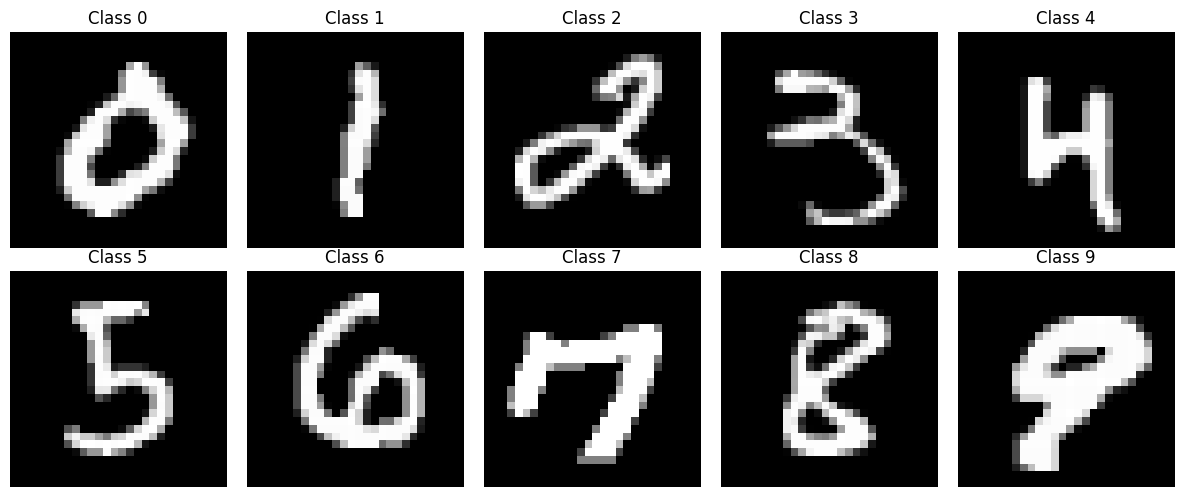

In [4]:
# Get indices of 10 different classes in the dataset, then get values
sampled_indices = [np.random.choice(np.where(np.array(train_set.targets) == i)[0]) for i in range(10)]
examples = train_set.data[sampled_indices]

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

# Plot examples
for i in range(len(examples)):
    img = examples[i]
    if dataset == 'mnist':
        img = img.squeeze(0)  # Remove the channel dimension for MNIST
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Class {i}')
    else:
        axes[i].imshow(img)
        axes[i].set_title(f'Class {i}:{cifar10_classes[train_set.targets[sampled_indices[i]]]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### Define a CNN class

*Remember the following:
*
            
- Remember here, that the amount of parameters in a convolutional layer is $(n * m * l + 1) * k$  
   - *Where* $n, m$ *is the kernel size* $(x, y)$, $l$ *is the input channels*, *and* $k$ *is the* $\text{output channels} + 1$, *is beacuse of a bias term that is done for each input*
  - *Basically*, $n * m * l$ *corresponds to kernels mapping to values in another "image"*
  - *Each kernel has a bias term unique to it. Each kernel produces one "image", that are then stacked on top of each other, for a total of* $k$ *images*.
  - *CONV2D does NOT flip the kernel!!!*
    - *But, it doesn't really mattter, since it is just learned anyways...*

*Finally, I found an answer on if it is better to ReLU first or Max Pool first... it kinda doesn't matter*
- *[But it is slightly better to maxpool first, max-pooling and monotonely increasing non-linearities commute. This means that MaxPool(Relu(x)) = Relu(MaxPool(x)) for any input](https://stackoverflow.com/questions/35543428/activation-function-after-pooling-layer-or-convolutional-layer
) *

In [144]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes, in_channels=1, features_fore_linear=64*6*6, lr=0.001):
        super().__init__()

        # Define layers as a torch.nn.Sequential object
        # This is pretty nice, since we can just go layers(input) to get output
        # Rather than having a bunch of functions in the forward function
        self.layers = torch.nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1), # dim = in
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=features_fore_linear, out_features=600),
            nn.Linear(in_features=600, out_features=120),
            nn.Linear(in_features=120, out_features=num_classes)
        ).to(device)
                
        # Loss function and optimizer, as you know, Adam is meta
        self.criterion = nn.CrossEntropyLoss()
        self.optim = torch.optim.Adam(self.layers.parameters(), lr=lr)

    def forward(self, x):
        return self.layers(x)

    def train(self, train_dataloader, epochs=1, val_dataloader=None):
        
        # To hold accuracy during training and testing
        train_accs = []
        test_accs = []

        for epoch in range(epochs):
            
            epoch_acc = 0

            for inputs, targets in tqdm(train_dataloader):
                logits = self.forward(inputs)
                loss = self.criterion(logits, targets)
                loss.backward()

                self.optim.step()
                self.optim.zero_grad()

                # Not actually used for training, just for keeping track of accuracy
                epoch_acc += (torch.argmax(logits, dim=1) == targets).sum().item()

            train_accs.append(epoch_acc / len(train_dataloader.dataset))

            # If we have val dataloader, we can evaluate after each epoch
            if val_dataloader is not None:
                acc = self.eval(val_dataloader)
                test_accs.append(acc)
                print(f"Epoch {epoch} validation accuracy: {acc}")
        
        return train_accs, test_accs

    def eval(self, test_dataloader):
        
        total_acc = 0

        for input_batch, label_batch in test_dataloader:
            # Get predictions
            logits = self(input_batch)

            # Remember, outs are probabilities (so there's 10 for each input)
            # The classification the network wants to assign, must therefore be the probability with the larget value
            # We find that using argmax (dim=1, because dim=0 would be across batch dimension)
            classifications = torch.argmax(logits, dim=1)
            total_acc += (classifications == label_batch).sum().item()

        total_acc = total_acc / len(test_dataloader.dataset)

        return total_acc

### A small hack

*Normally, you have to ask ChatGPT, a friend or the dark Gods to find out what the dimensionality of the data is before the first linear layer (why has Torch not implemented this automatically????) Anyways, the below function solves that, while still being a bit cursed*

In [145]:
def get_dim_before_first_linear(layers, in_dim, in_channels, brain=False):
    """
    Assume square in dimensions, square kernels, cuz I'm lazy
    Also assume kernel numbers and channels match up, because that's trivial enough
    """

    current_dim = in_dim
    current_channels = in_channels
    for layer in layers:
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.MaxPool2d):
            # If the layer padding is same we do not need to change the dimension of the input
            if layer.padding == 'same':
                continue
                if isinstance(layer, nn.Conv2d):
                    current_channels = layer.out_channels

            vals = {
                'kernel_size': layer.kernel_size if isinstance(layer.kernel_size, int) else layer.kernel_size[0],
                'stride': layer.stride if isinstance(layer.stride, int) else layer.stride[0],
                'padding': layer.padding if isinstance(layer.padding, int) else layer.padding[0],
                'dilation': layer.dilation if isinstance(layer.dilation, int) else layer.dilation[0]
            }
            current_dim = (current_dim + 2*vals['padding'] - vals['dilation']*(vals['kernel_size'])) // vals['stride'] + 1

        if isinstance(layer, nn.Conv2d):
            current_channels = layer.out_channels

        if isinstance(layer, nn.Linear):
            if brain:
                return current_dim, current_channels
            else:
                return current_dim * current_dim * current_channels
        
    raise ValueError("No linear layer found in layers! Why are you even asking me?")

### Training the CNN

*Putting it all together, we should be able to train the CNN*

100%|██████████| 3125/3125 [00:06<00:00, 510.28it/s]


Epoch 0 validation accuracy: 0.603


100%|██████████| 3125/3125 [00:06<00:00, 520.71it/s]


Epoch 1 validation accuracy: 0.6515


100%|██████████| 3125/3125 [00:05<00:00, 525.64it/s]


Epoch 2 validation accuracy: 0.6446


100%|██████████| 3125/3125 [00:06<00:00, 516.20it/s]


Epoch 3 validation accuracy: 0.6483


100%|██████████| 3125/3125 [00:05<00:00, 521.85it/s]


Epoch 4 validation accuracy: 0.6764


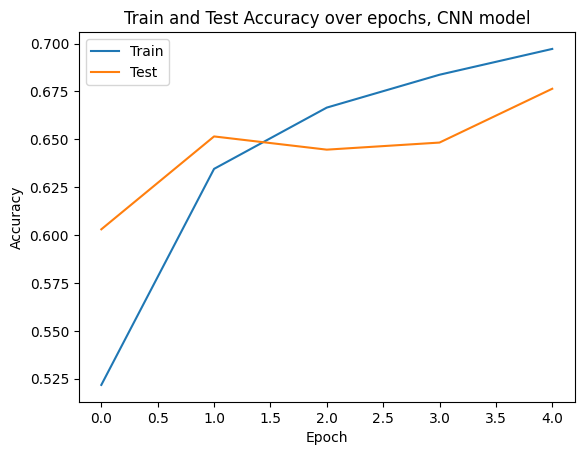

In [182]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False, collate_fn=collate_fn)

in_channels = next(iter(train_dataloader))[0].shape[1]
in_width_height = next(iter(train_dataloader))[0].shape[-1]

# Make a dummy model to find out the size before the first linear layer
CNN_model = CNN(num_classes=10, in_channels=in_channels, lr=0.001)
feats_fore_linear = get_dim_before_first_linear(CNN_model.layers, in_width_height, in_channels, brain=False)

# Now make true model when we know how many features we have before the first linear layer
CNN_model = CNN(num_classes=10, in_channels=in_channels, features_fore_linear=feats_fore_linear, lr=0.001) 

train_epochs = 5
train_accs, test_accs = CNN_model.train(train_dataloader, epochs=train_epochs,  val_dataloader=test_dataloader)
# CNN_model.eval(test_dataloader)

# plot train and test accuracies
plt.plot(range(train_epochs), train_accs, label='Train')
plt.plot(range(train_epochs), test_accs, label='Test')


plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over epochs, CNN model')
plt.legend()
plt.show()

### Exercise 2.1

**1. Reason a bit about why the training and test accuracy look as they do? One question could be: Why is the training accuracy lower than the test accuracy for the first epoch?**

ANSWER: This is really mostly an implementation issue. Basically the training accuracy starts being counted right from the first inference point, meaning that it essentially makes 'blind inference' for the first few tests.

Other than that, they look pretty normal. Test accuracy is as expected, worse than train accuracy, but not by much, so we can't really say it has overfitted in any meaningful way.

**2. Make the network also save the average losses over each epoch as it trains. What does the loss after each epoch tell you about the state of its training?**

$\dots$

**3. Can you use the training loss as a measure for the performance of your model?**

ANSWER: Hell no. The training loss is only a measure of how well the model is able to fit to the training data. The only real thing it can tell us, is how much our weights are being updated.

We should evaluate performance only on the test set (or, if tuning hyperparameters, the validation set).

**4. Try changing some of the hyperparameters of the network (layers, epochs, learning rate, etc.), are you able to achieve a better test accuracy?**

**5. Try changing some other hyperparameters, are you able to make the network *overfit?* Reason about why or why your are not able to.**

ANSWER: In the case of MNIST it might be because the dataset is damn simple and large, so there aren't any super example-specific cases that the model can overfit to (not without many more parameters anyway)

Perhaps you might be able to with the CIFAR10 dataset, if not, try lowering the amount of train data, that gives the network fewer examples to run on for more epochs potentailly.

**6. Look into the torch documentatation for [saving and loading models](https://pytorch.org/tutorials/beginner/saving_loading_models.html), try to complete the functions for saving and loading your model resepectively**

## Defining a feedforward neural network (FFNN) class

*Here, we don't need to reinvent the wheel, so we just subclass from our existing CNN model to inherit all useful attributes*

In [149]:
class FFNN(CNN):
    def __init__(self, in_features, num_classes, lr=0.001):
        # We have to give it dummy values, otherwise intialization will not work
        super().__init__(num_classes=num_classes, in_channels=1, lr=0.001)
        
        self.num_classes = num_classes

        self.layers = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=num_classes)
        ).to(device)

        self.criterion = nn.CrossEntropyLoss()
        self.optim = torch.optim.Adam(self.layers.parameters(), lr=lr)
            

    def forward(self, x):
        x = x.flatten(start_dim=1)
        # Super unucesseary, but wanted to show that you can call the parent class' forward function
        return super().forward(x)




1024
torch.Size([16, 3, 32, 32])


100%|██████████| 3125/3125 [00:04<00:00, 740.02it/s]


Epoch 0 validation accuracy: 0.3205


100%|██████████| 3125/3125 [00:04<00:00, 717.59it/s]


Epoch 1 validation accuracy: 0.3611


100%|██████████| 3125/3125 [00:04<00:00, 685.76it/s]


Epoch 2 validation accuracy: 0.3698


100%|██████████| 3125/3125 [00:04<00:00, 709.07it/s]


Epoch 3 validation accuracy: 0.3918


100%|██████████| 3125/3125 [00:04<00:00, 706.29it/s]


Epoch 4 validation accuracy: 0.391


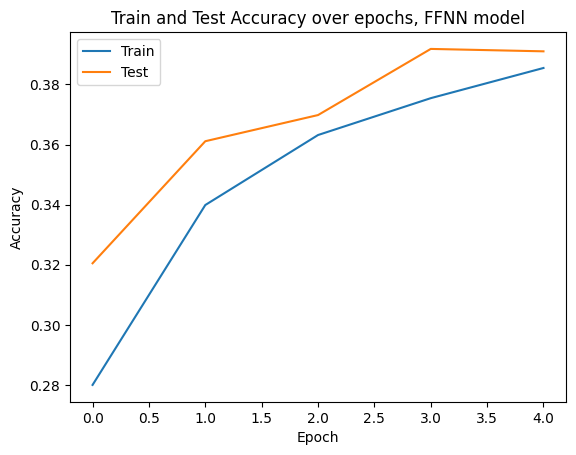

In [158]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Num in_channels really shouldn't be above 1, the FFNN probably can't handle that well
num_in_channels = next(iter(train_dataloader))[0].shape[1]
in_width_height = next(iter(train_dataloader))[0].shape[-1]

FFNN_model = FFNN(in_features=num_in_channels*in_width_height**2,num_classes=10, lr=0.001)

train_epochs = 5
train_accs, test_accs = FFNN_model.train(train_dataloader, epochs=train_epochs, val_dataloader=test_dataloader)

# plot train and test accuracies
plt.plot(range(train_epochs), train_accs, label='Train')
plt.plot(range(train_epochs), test_accs, label='Test')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy over epochs, FFNN model')
plt.legend()
plt.show()

## Exercise 2.2

**1. Test the FFNN model for both the CIFAR10 and the MNIST dataset. There should be a *huge* difference in test accuracy when using CIFAR10 compared to MNIST. Explain this gap, and why this gap is comparatively smaller for the CNN model**

ANSWER: MNIST, in being so simple that it is, doesn't really have much spatial information. How pixels are in realtion to one another does not have as big an effect as in CIFAR10, making the task much more doable for the poor FFNN. The CNN model does not lack spatial awareness, and such does not experience that big a drop in performance from MNIST to CIFAR10, most of it simply being because CIFAR10 is a harder task in general.

**2. It should be obvious, that the FFNN model is inferior in terms of test accuracy for this particular task... Does it have any advantages over the CNN?**

ANSWER: Two reasons mainly:

- It's faster (normally). This can be especially worthwhile for implementations on mobile phones or other cases where inference time is critical or you have limited resources
- It's easier to explain. People don't really trust models further than they can throw them. Having an easier-to-implement model also reduces the chance of human error in said implentation, which is **very** worthwhile

**3. Try changing the layer structure of your FFNN to see if you can achieve a similar or better test accuracy on CIFAR10 than the CNN. Alternatively, try to see how much you need to hamstring the layers of the CNN to pull it down to the performance level of the FFNN.**



### Exercise 2.3

*Obviously, the accuracy of either network is not 100\%, but why this is can be either due to the network simply being bad, or the task being difficult. Plotting the misclassified images is often a good way to get some information on which one it is.*

**1. Use the below function to plot a few of the misclassified images of both the FFNN and the CNN. Do the misclassified images of either model have anything in common?**

$\dots$

**2. Change the 'sorted' parameter to True to make the function only take images with the lowest maximum prediction certainty. Are these different from the ones that were mere misclassified?**

$\dots$

In [ ]:
# TODO: PLOT SOME MISCLASSIFIED IMAGES HERE

### Displaying the output of the convlutional layers

*Sometimes it is interesting to actually examine how the convolutions in the CNN actually look, to reason about what the model learns. We do this by using Torch's 'forward hooks' - functions that you can apply to layers, that will then be called after the layer performs a forward pass. This can be useful for a bunch of different things, including adding BatchNorm to your model... We just use it to capture the output of each layer*

### Exercise 2.4

# TODO: TEST THIS WHEN YOU CHANGE THE AMOUNT OF LAYERS AND SHIT

*The below code plots the intermediary outputs of the kernels of either an untrained CNN model, or your trained model. We can examine this output to get an idea of the kind of feature extraction the convolutional layers actually perform.*

**1. Consider the intermediary kernel outputs of both a trained and an untrained CNN model, how do they differ?**

ANSWER: This is very hard to see in simplistic examples such as this. You should however be able to see the trained model SOMEWHAT focusing better on the cat in the image below... somewhat.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


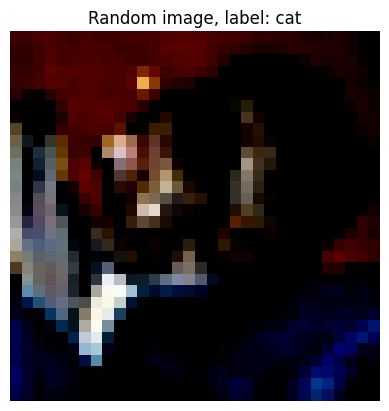

torch.Size([1, 3, 32, 32])
Layer: layers.0, Activation Shape: torch.Size([1, 32, 32, 32])
Layer: layers.3, Activation Shape: torch.Size([1, 64, 14, 14])


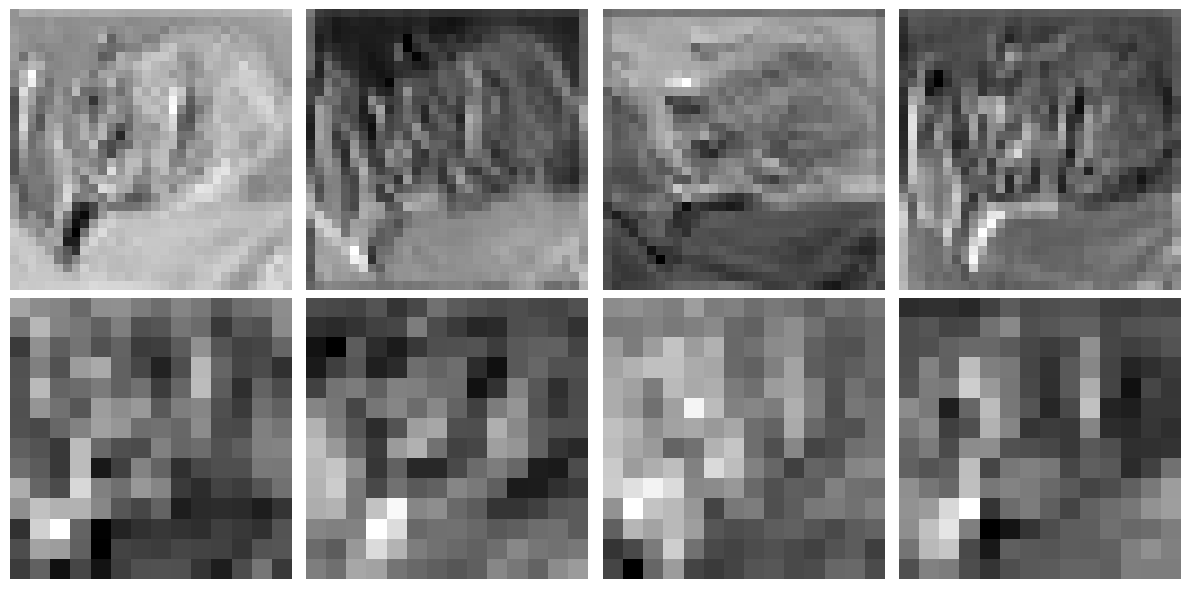

In [186]:
trained_model = False

if trained_model is False:
    # Initialize a dummy untrained CNN model to compare activations with
    in_channels = next(iter(train_dataloader))[0].shape[1]
    in_width_height = next(iter(train_dataloader))[0].shape[-1]
    feats_fore_linear = get_dim_before_first_linear(CNN_model.layers, in_width_height, in_channels, brain=False)
    model = CNN(num_classes=10, in_channels=in_channels, features_fore_linear=feats_fore_linear, lr=0.001) 

else:
    # Otherwise use a trained model
    model = CNN_model

# Dict to hold network activations
activations = {}

# Hook function, is a type of wrapper function that is then called whenever layer registered with it is run
def forward_hook(layer_name, capture_dict):
    def hook(module, input, output):
        capture_dict[layer_name] = output
    return hook

# Register hooks for all Conv2d layers model
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d):
        layer.register_forward_hook(forward_hook(name, activations))

# Get just a single example from the test dataloader
input_image, input_label = next(iter(test_dataloader))
input_image, input_label = input_image[0].unsqueeze(0).to('cpu'), input_label[0].unsqueeze(0).to('cpu').numpy()[0]

# Plot the image before convolutions
if dataset == 'mnist':
    plt.imshow(input_image.squeeze().numpy(), cmap='gray')
    plt.title(f'Random image, label: {input_label}')

elif dataset == 'cifar10':
    plt.imshow(input_image.squeeze().transpose(0, 2).transpose(0, 1).numpy())
    plt.title(f'Random image, label: {cifar10_classes[input_label]}')
plt.axis('off')  # Hide axis
plt.show()

# Forward pass - Use torch.no_grad() to not store gradients, since we are only interested in activations
with torch.no_grad():
    print(input_image.shape)
    output = model(input_image.to(device))

# Display the captured activations
for layer_name, activation in activations.items():
    print(f"Layer: {layer_name}, Activation Shape: {activation.shape}")

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, (layer_name, activation) in enumerate(activations.items()):
    for j in range(4):
        axes[i, j].imshow(activation[0, j, ...].to('cpu'), cmap='gray')
        axes[i, j].axis('off') 

plt.tight_layout()
plt.show()